In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
import pandas as pd

import ysy_mamplot as mb
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Control-off

In [2]:
data = pd.read_csv('control_off_simulink_sim_output_data_202512232355.csv')
data

,t,y_VL,y_HL,y_VR,y_HR,ns
0,0.0000,4.069135e-07,4.069135e-07,4.069135e-07,4.069135e-07,4.069135e-07
1,0.0001,7.966246e-07,7.284194e-07,7.537128e-07,4.923210e-07,6.103702e-07
2,0.0002,9.831370e-07,8.479066e-07,8.967916e-07,3.728337e-07,6.103702e-07
3,0.0003,1.176577e-06,9.601940e-07,1.049416e-06,2.605464e-07,6.103702e-07
4,0.0004,1.355233e-06,1.066721e-06,1.189352e-06,1.540194e-07,6.103702e-07
...,...,...,...,...,...,...
4999996,499.9996,-2.934429e-06,1.435322e-05,-9.446297e-06,-1.435322e-05,0.000000e+00
4999997,499.9997,-2.177641e-06,1.498874e-05,-8.628783e-06,-1.336109e-05,8.138269e-07
4999998,499.9998,-2.651403e-06,1.439487e-05,-9.038662e-06,-1.358104e-05,4.069135e-07
4999999,499.9999,-2.520027e-06,1.441280e-05,-8.843907e-06,-1.319206e-05,6.103702e-07


In [3]:
t = data['t'].values

y_VL_o = data['y_VL'].values
y_HL_o = data['y_HL'].values

y_VR_o = data['y_VR'].values

ns = data['ns'].values

In [4]:
y_V_o = (y_VL_o + y_VR_o) / 2
y_R_o = (y_VL_o - y_VR_o) / 2 + ns
y_H_o = y_HL_o

In [5]:
Ts = np.mean(np.diff(t))
fs = 1 / Ts
T = t[-1]
L = len(t)
Delta_f = 0.05
T_eff = 1/Delta_f
M = fs * T_eff
print('The Welch K: ', L/M)

The Welch K:  25.000005


In [6]:
# 辅助函数
def fast_d_asd(data, fs=fs, M=M, Delta_f=Delta_f, f_max=1000):
    f, pxx = welch(data, fs=fs, nperseg=M)
    mask = (f > Delta_f) & (f < f_max) 
    # mask = (f > Delta_f)
    d_asd = np.sqrt(pxx[mask]) / (2 * np.pi * f[mask])
    return f[mask], d_asd

In [7]:
f, d_asd_V_o = fast_d_asd(y_V_o)
_, d_asd_R_o = fast_d_asd(y_R_o)
_, d_asd_H_o = fast_d_asd(y_H_o)

_, d_asd_VL_o = fast_d_asd(y_VL_o)
_, d_asd_HL_o = fast_d_asd(y_HL_o)
_, d_asd_VR_o = fast_d_asd(y_VR_o)

_, d_asd_ns = fast_d_asd(ns)

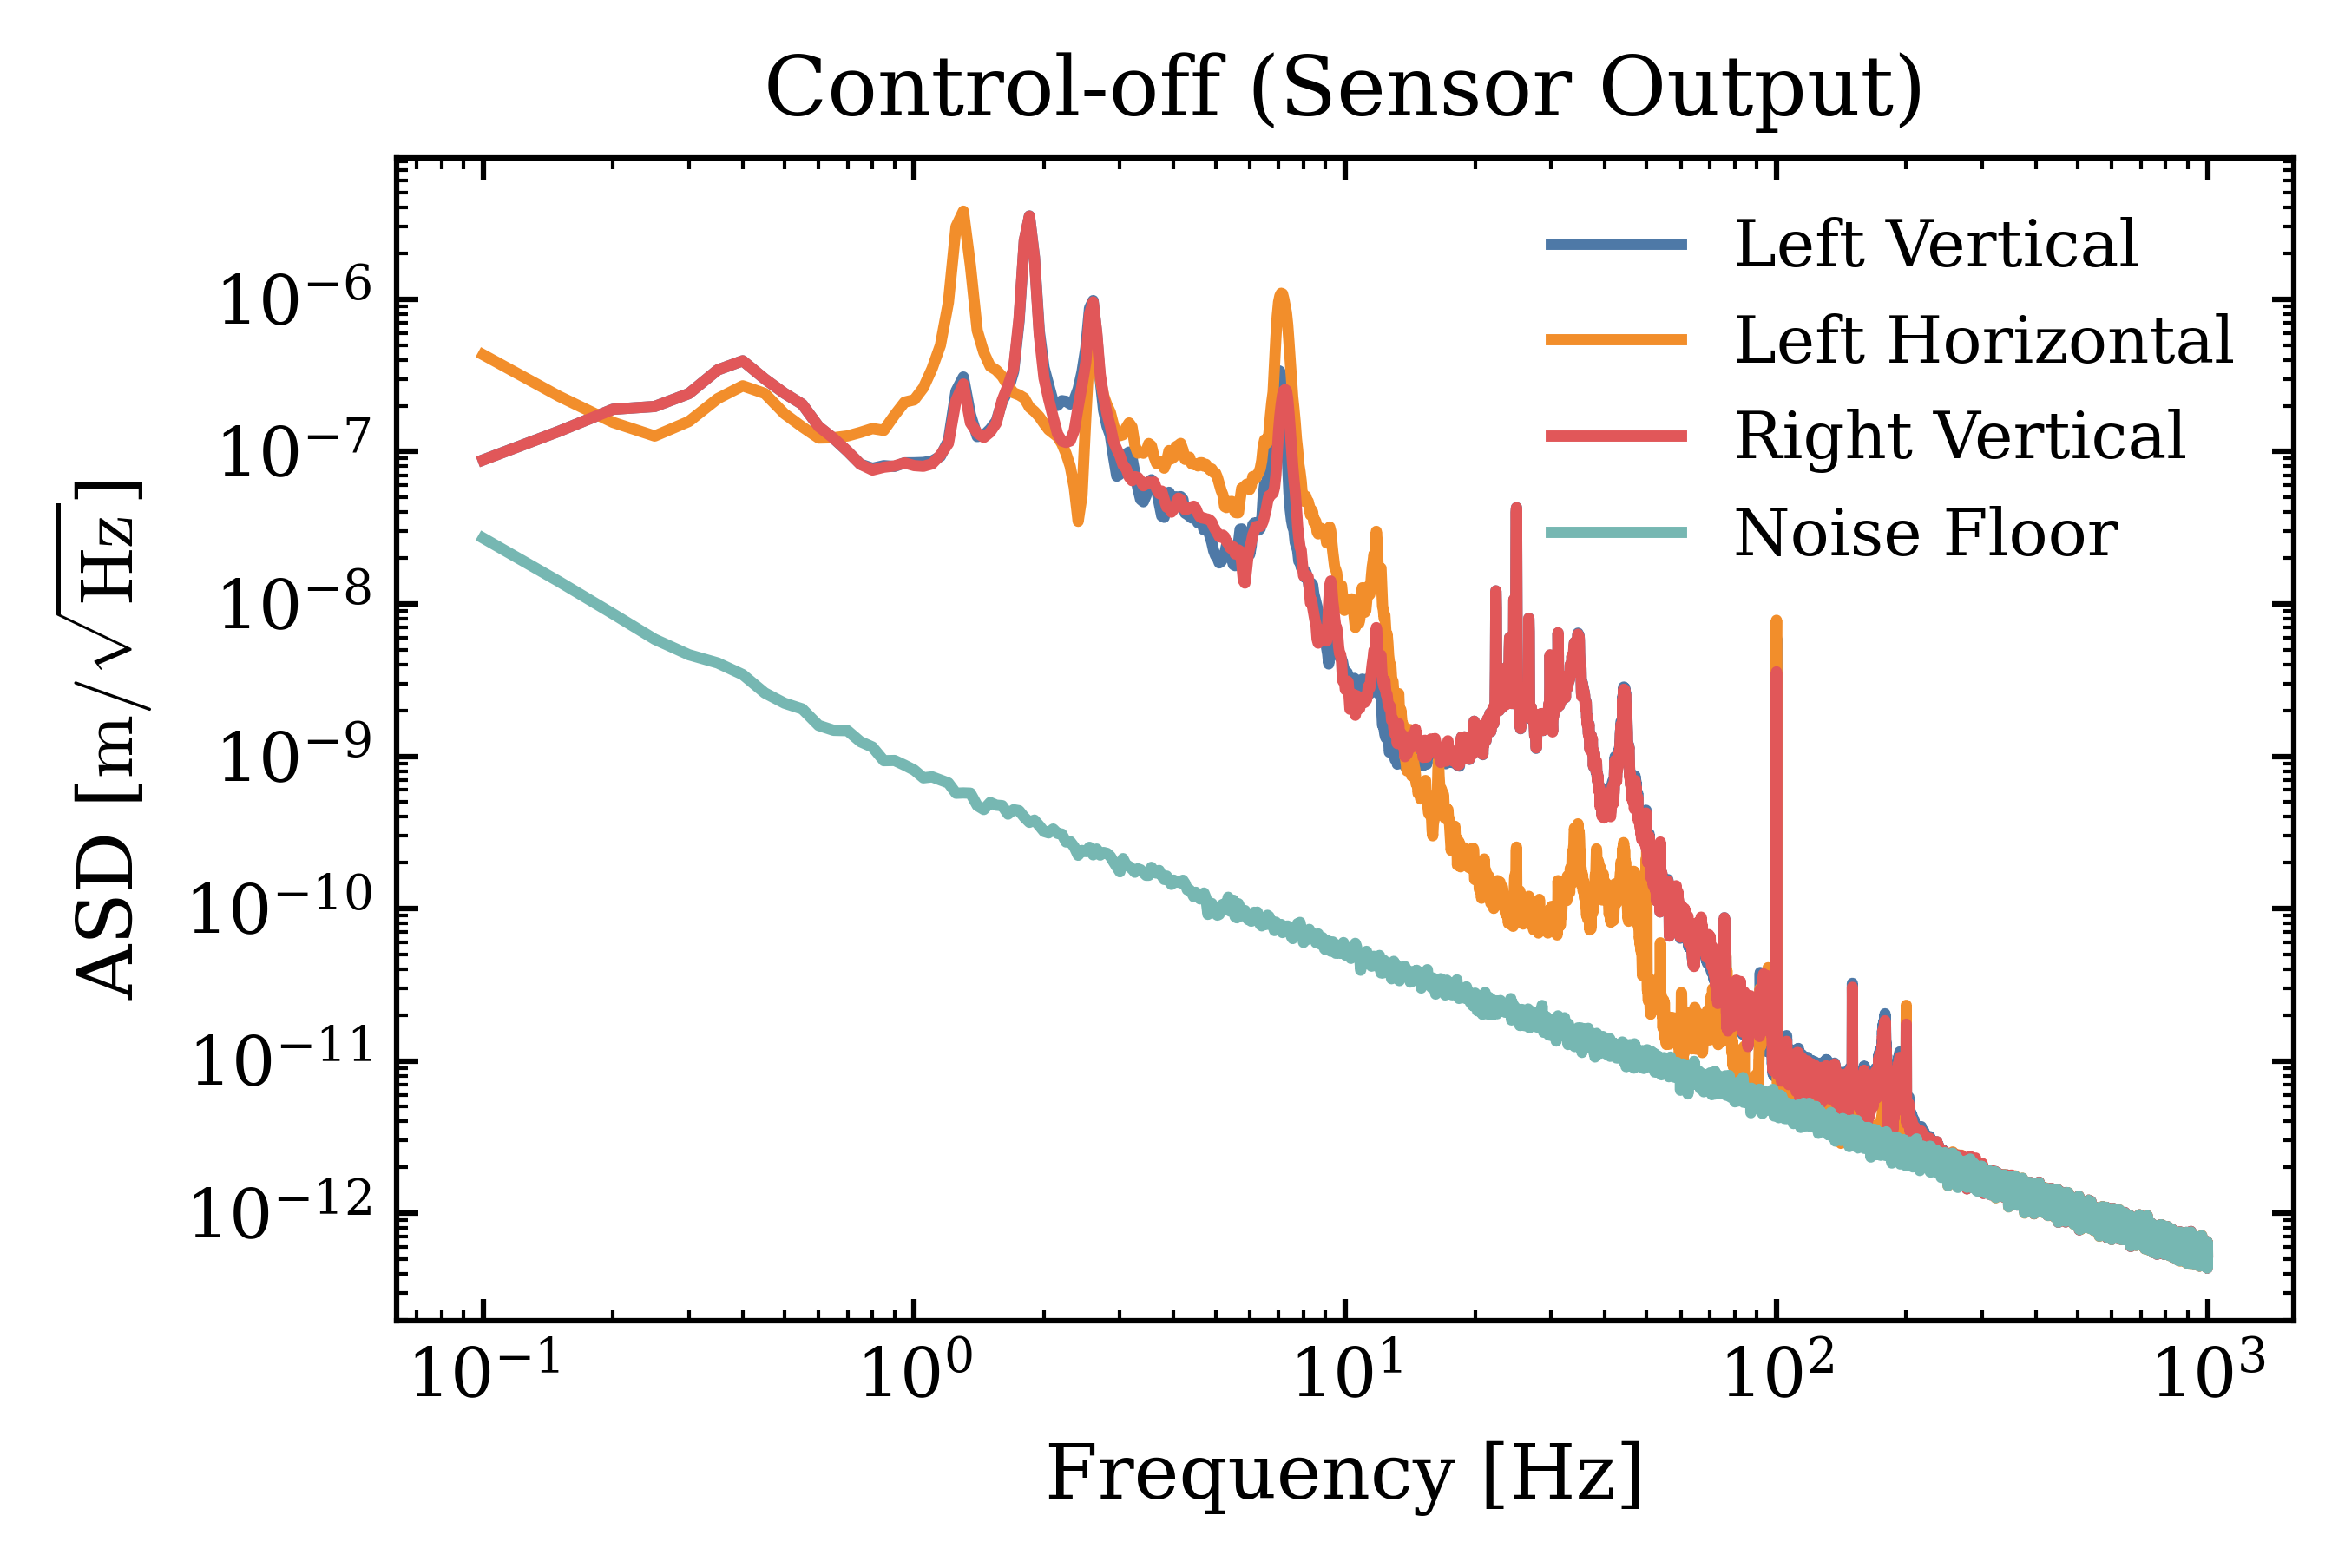

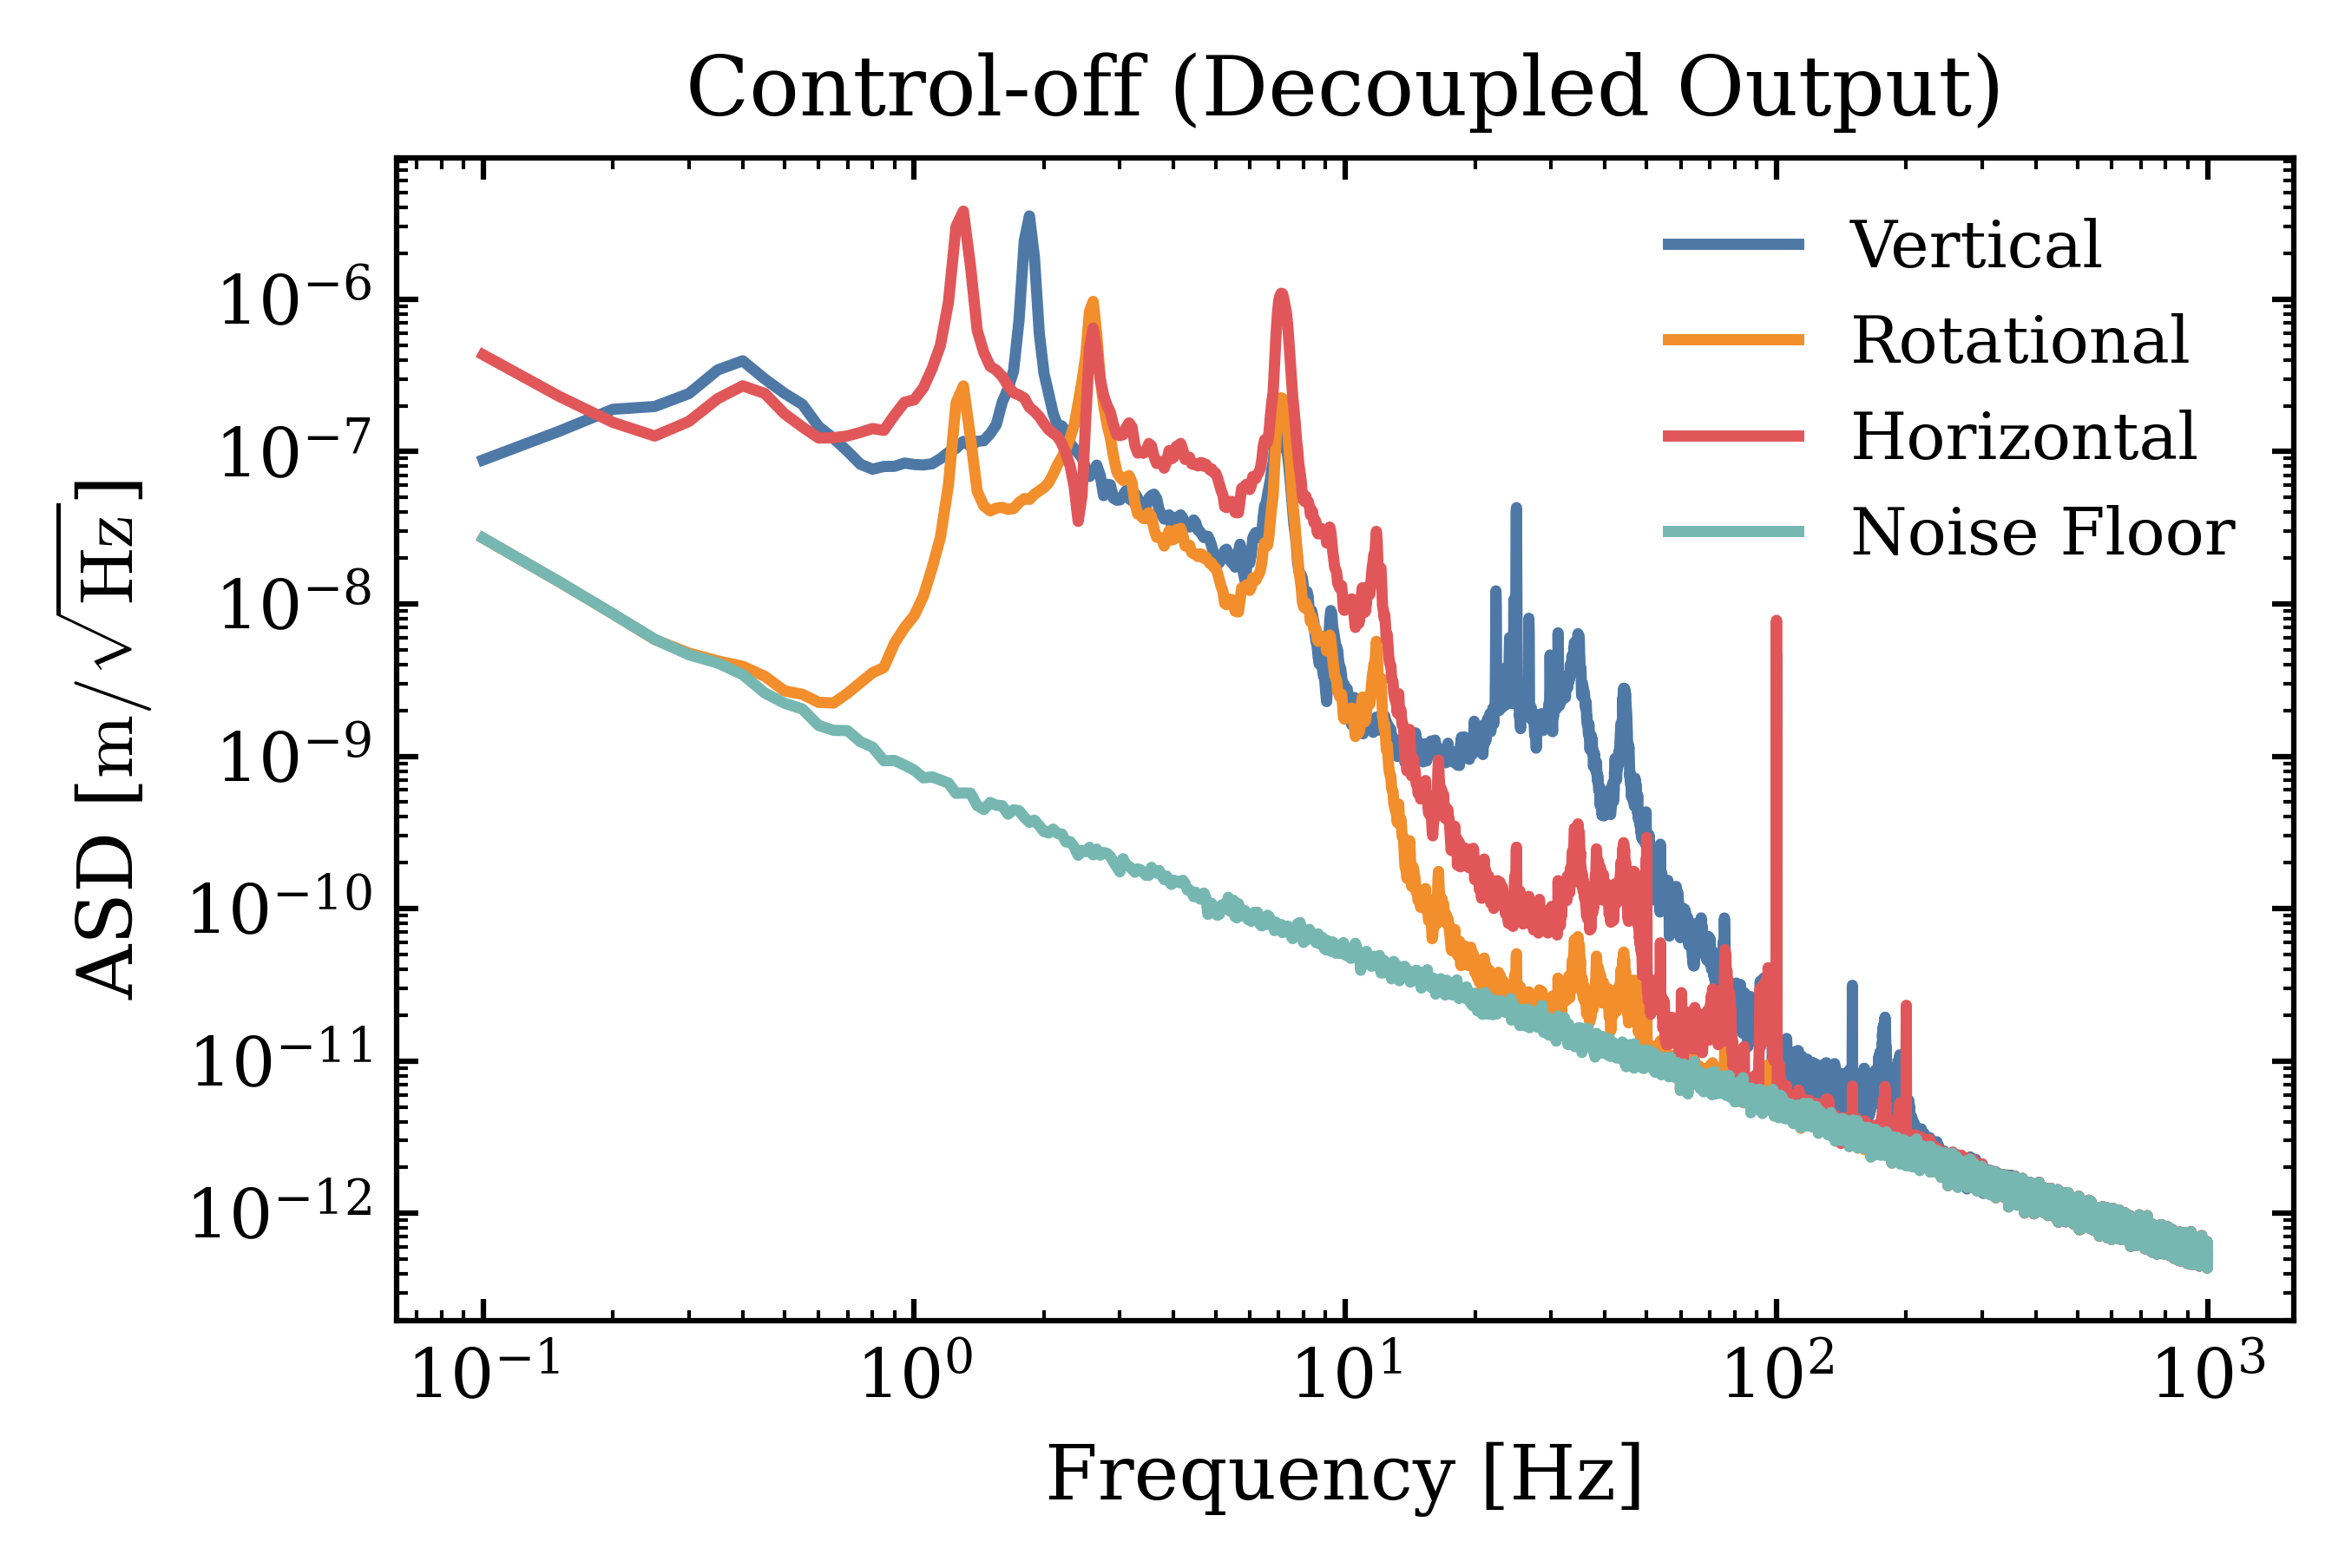

In [8]:
mb.mamplot(
    f, (d_asd_VL_o, d_asd_HL_o, d_asd_VR_o, d_asd_ns),
    ('Left Vertical', 'Left Horizontal', 'Right Vertical', 'Noise Floor'), 
    'Control-off (Sensor Output)',
    'Frequency [Hz]', 'ASD [$\mathrm{m/\sqrt{Hz}}$]',
    logx=True, logy=True, 
    legend_out=False, legend_fancy=False
)

mb.mamplot(
    f, (d_asd_V_o, d_asd_R_o, d_asd_H_o, d_asd_ns),
    ('Vertical', 'Rotational', 'Horizontal', 'Noise Floor'), 
    'Control-off (Decoupled Output)',
    'Frequency [Hz]', 'ASD [$\mathrm{m/\sqrt{Hz}}$]',
    logx=True, logy=True, 
    legend_out=False, legend_fancy=False
)

## Decoupled LQG

In [ ]:
data2 = pd.read_csv('closeloop_simulink_sim_output_data_202512232053.csv')
data2

In [17]:
# 重采样
from scipy.interpolate import interp1d
fs = 10_000
dt = 1.0 / fs

t_old = data2['t'].values

f1 = interp1d(t_old, data2['y_Vc'].values, kind='linear')
y_V_c1 = f1(t)
f2 = interp1d(t_old, data2['y_Vd'].values, kind='linear')
y_R_c1 = f2(t)
f3 = interp1d(t_old, data2['y_H'].values, kind='linear')
y_H_c1 = f3(t)

In [18]:
_, d_asd_V_c1 = fast_d_asd(y_V_c1)
_, d_asd_R_c1 = fast_d_asd(y_R_c1)
_, d_asd_H_c1 = fast_d_asd(y_H_c1)

In [ ]:
mb.mamplot(
    f, (d_asd_V_o, d_asd_V_c1, d_asd_ns), 
    ('Control-off', 'Control-on', 'Noise Floor'), 
    'Vertical (Decoupled LQG)',
    'Frequency [Hz]', 'ASD [$\mathrm{m/\sqrt{Hz}}$]',
    logx=True, logy=True, 
    legend_out=False, legend_fancy=False
)

mb.mamplot(
    f, (d_asd_R_o, d_asd_R_c1, d_asd_ns), 
    ('Control-off', 'Control-on', 'Noise Floor'), 
    'Rotational (Decoupled LQG)',
    'Frequency [Hz]', 'ASD [$\mathrm{m/\sqrt{Hz}}$]',
    logx=True, logy=True, 
    legend_out=False, legend_fancy=False
)

mb.mamplot(
    f, (d_asd_H_o, d_asd_H_c1, d_asd_ns), 
    ('Control-off', 'Control-on', 'Noise Floor'), 
    'Horizontal (Decoupled LQG)',
    'Frequency [Hz]', 'ASD [$\mathrm{m/\sqrt{Hz}}$]',
    logx=True, logy=True, 
    legend_out=False, legend_fancy=False
)

## LQG

In [9]:
data3 = pd.read_csv('control_on_simulink_sim_output_data_202512241141.csv')
data3

,t,y_VL,y_HL,y_VR,y_HR,ns
0,0.000000,4.069135e-07,4.069135e-07,4.069135e-07,4.069135e-07,4.069135e-07
1,0.000009,4.181838e-07,4.359714e-07,4.146363e-07,4.150361e-07,4.255037e-07
2,0.000018,4.240835e-07,4.645743e-07,4.174879e-07,4.236136e-07,4.440940e-07
3,0.000027,4.291417e-07,4.927037e-07,4.199762e-07,4.326647e-07,4.626842e-07
4,0.000100,4.538097e-07,6.970979e-07,4.363290e-07,5.236425e-07,6.103702e-07
...,...,...,...,...,...,...
10000054,499.999800,2.913359e-07,1.052772e-07,3.177716e-07,7.085498e-07,4.069135e-07
10000055,499.999852,3.863936e-07,2.071781e-07,4.127334e-07,8.172355e-07,5.122068e-07
10000056,499.999900,4.502069e-07,3.028103e-07,4.764470e-07,9.179301e-07,6.103702e-07
10000057,499.999948,1.900665e-07,3.431481e-09,2.169366e-07,6.283286e-07,3.158800e-07


In [10]:
# 重采样
from scipy.interpolate import interp1d

t_old = data3['t'].values

f4 = interp1d(t_old, data3['y_VL'].values, kind='linear')
y_VL_c2 = f4(t)
f5 = interp1d(t_old, data3['y_HL'].values, kind='linear')
y_HL_c2 = f5(t)
f6 = interp1d(t_old, data3['y_VR'].values, kind='linear')
y_VR_c2 = f6(t)

In [11]:
y_V_c2 = (y_VL_c2 + y_VR_c2) / 2
y_R_c2 = (y_VL_c2 - y_VR_c2) / 2 + ns
y_H_c2 = y_HL_c2

In [12]:
_, d_asd_VL_c2 = fast_d_asd(y_VL_c2)
_, d_asd_HL_c2 = fast_d_asd(y_HL_c2)
_, d_asd_VR_c2 = fast_d_asd(y_VR_c2)

_, d_asd_V_c2 = fast_d_asd(y_V_c2)
_, d_asd_R_c2 = fast_d_asd(y_R_c2)
_, d_asd_H_c2 = fast_d_asd(y_H_c2)

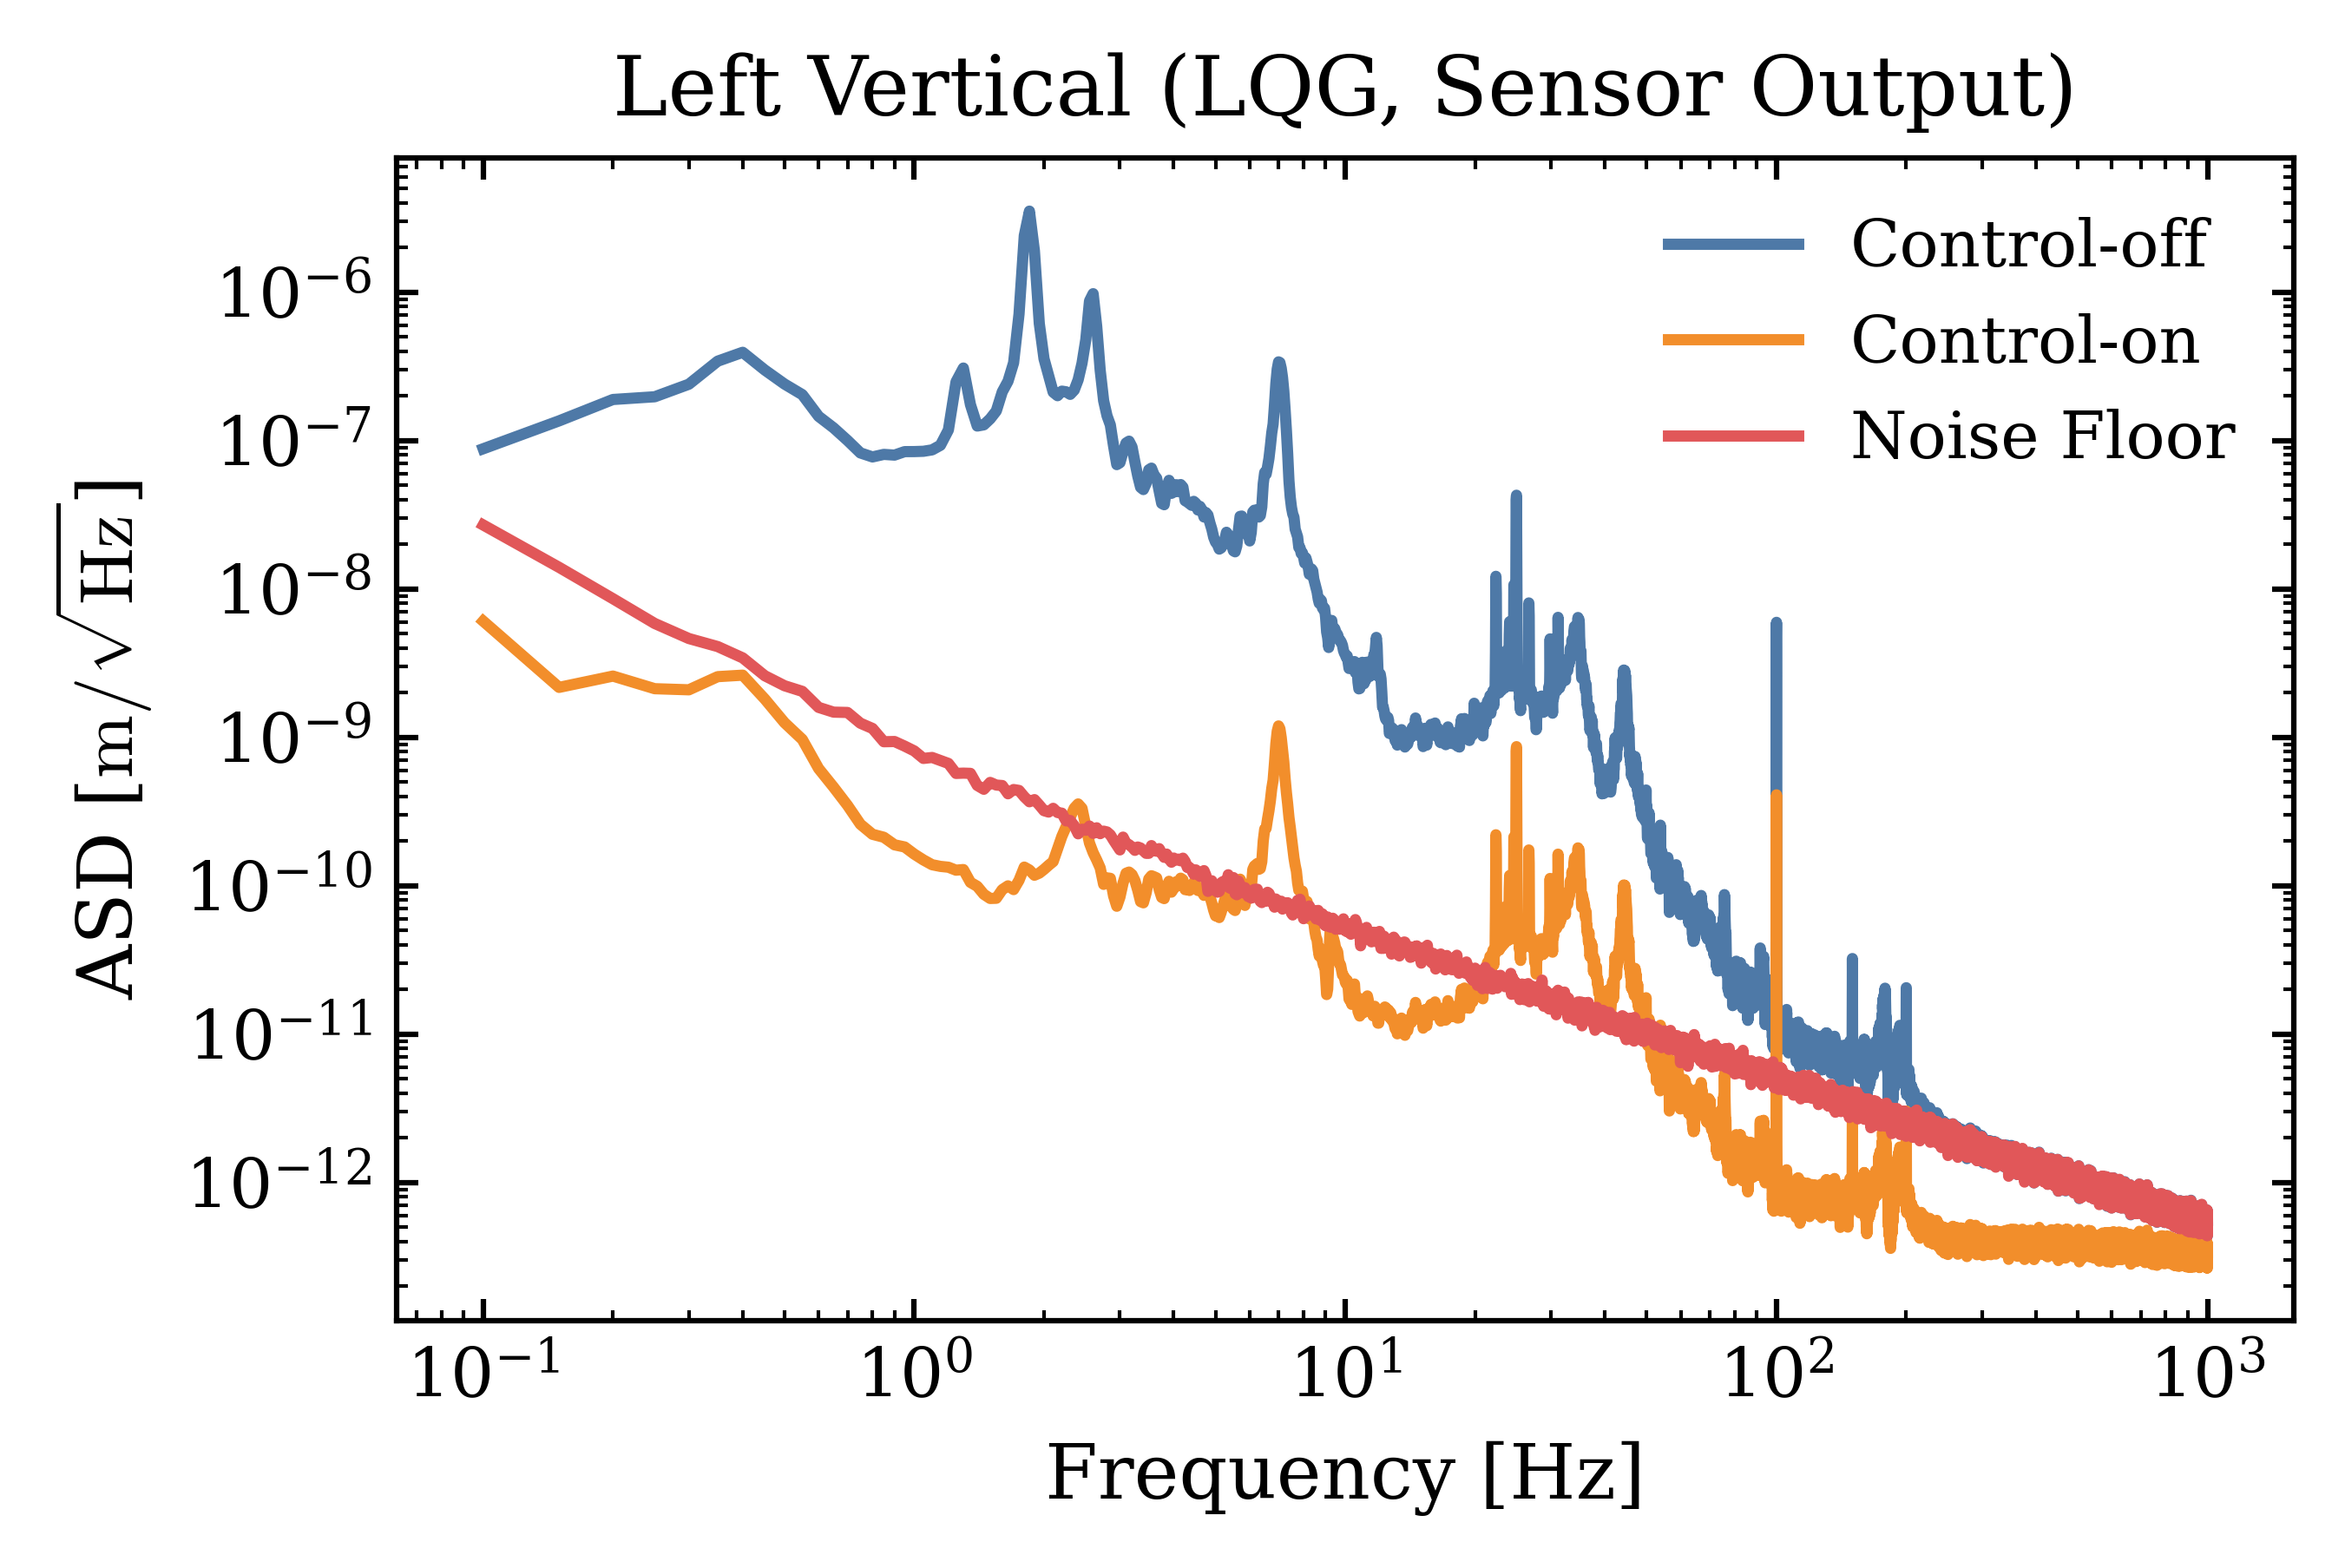

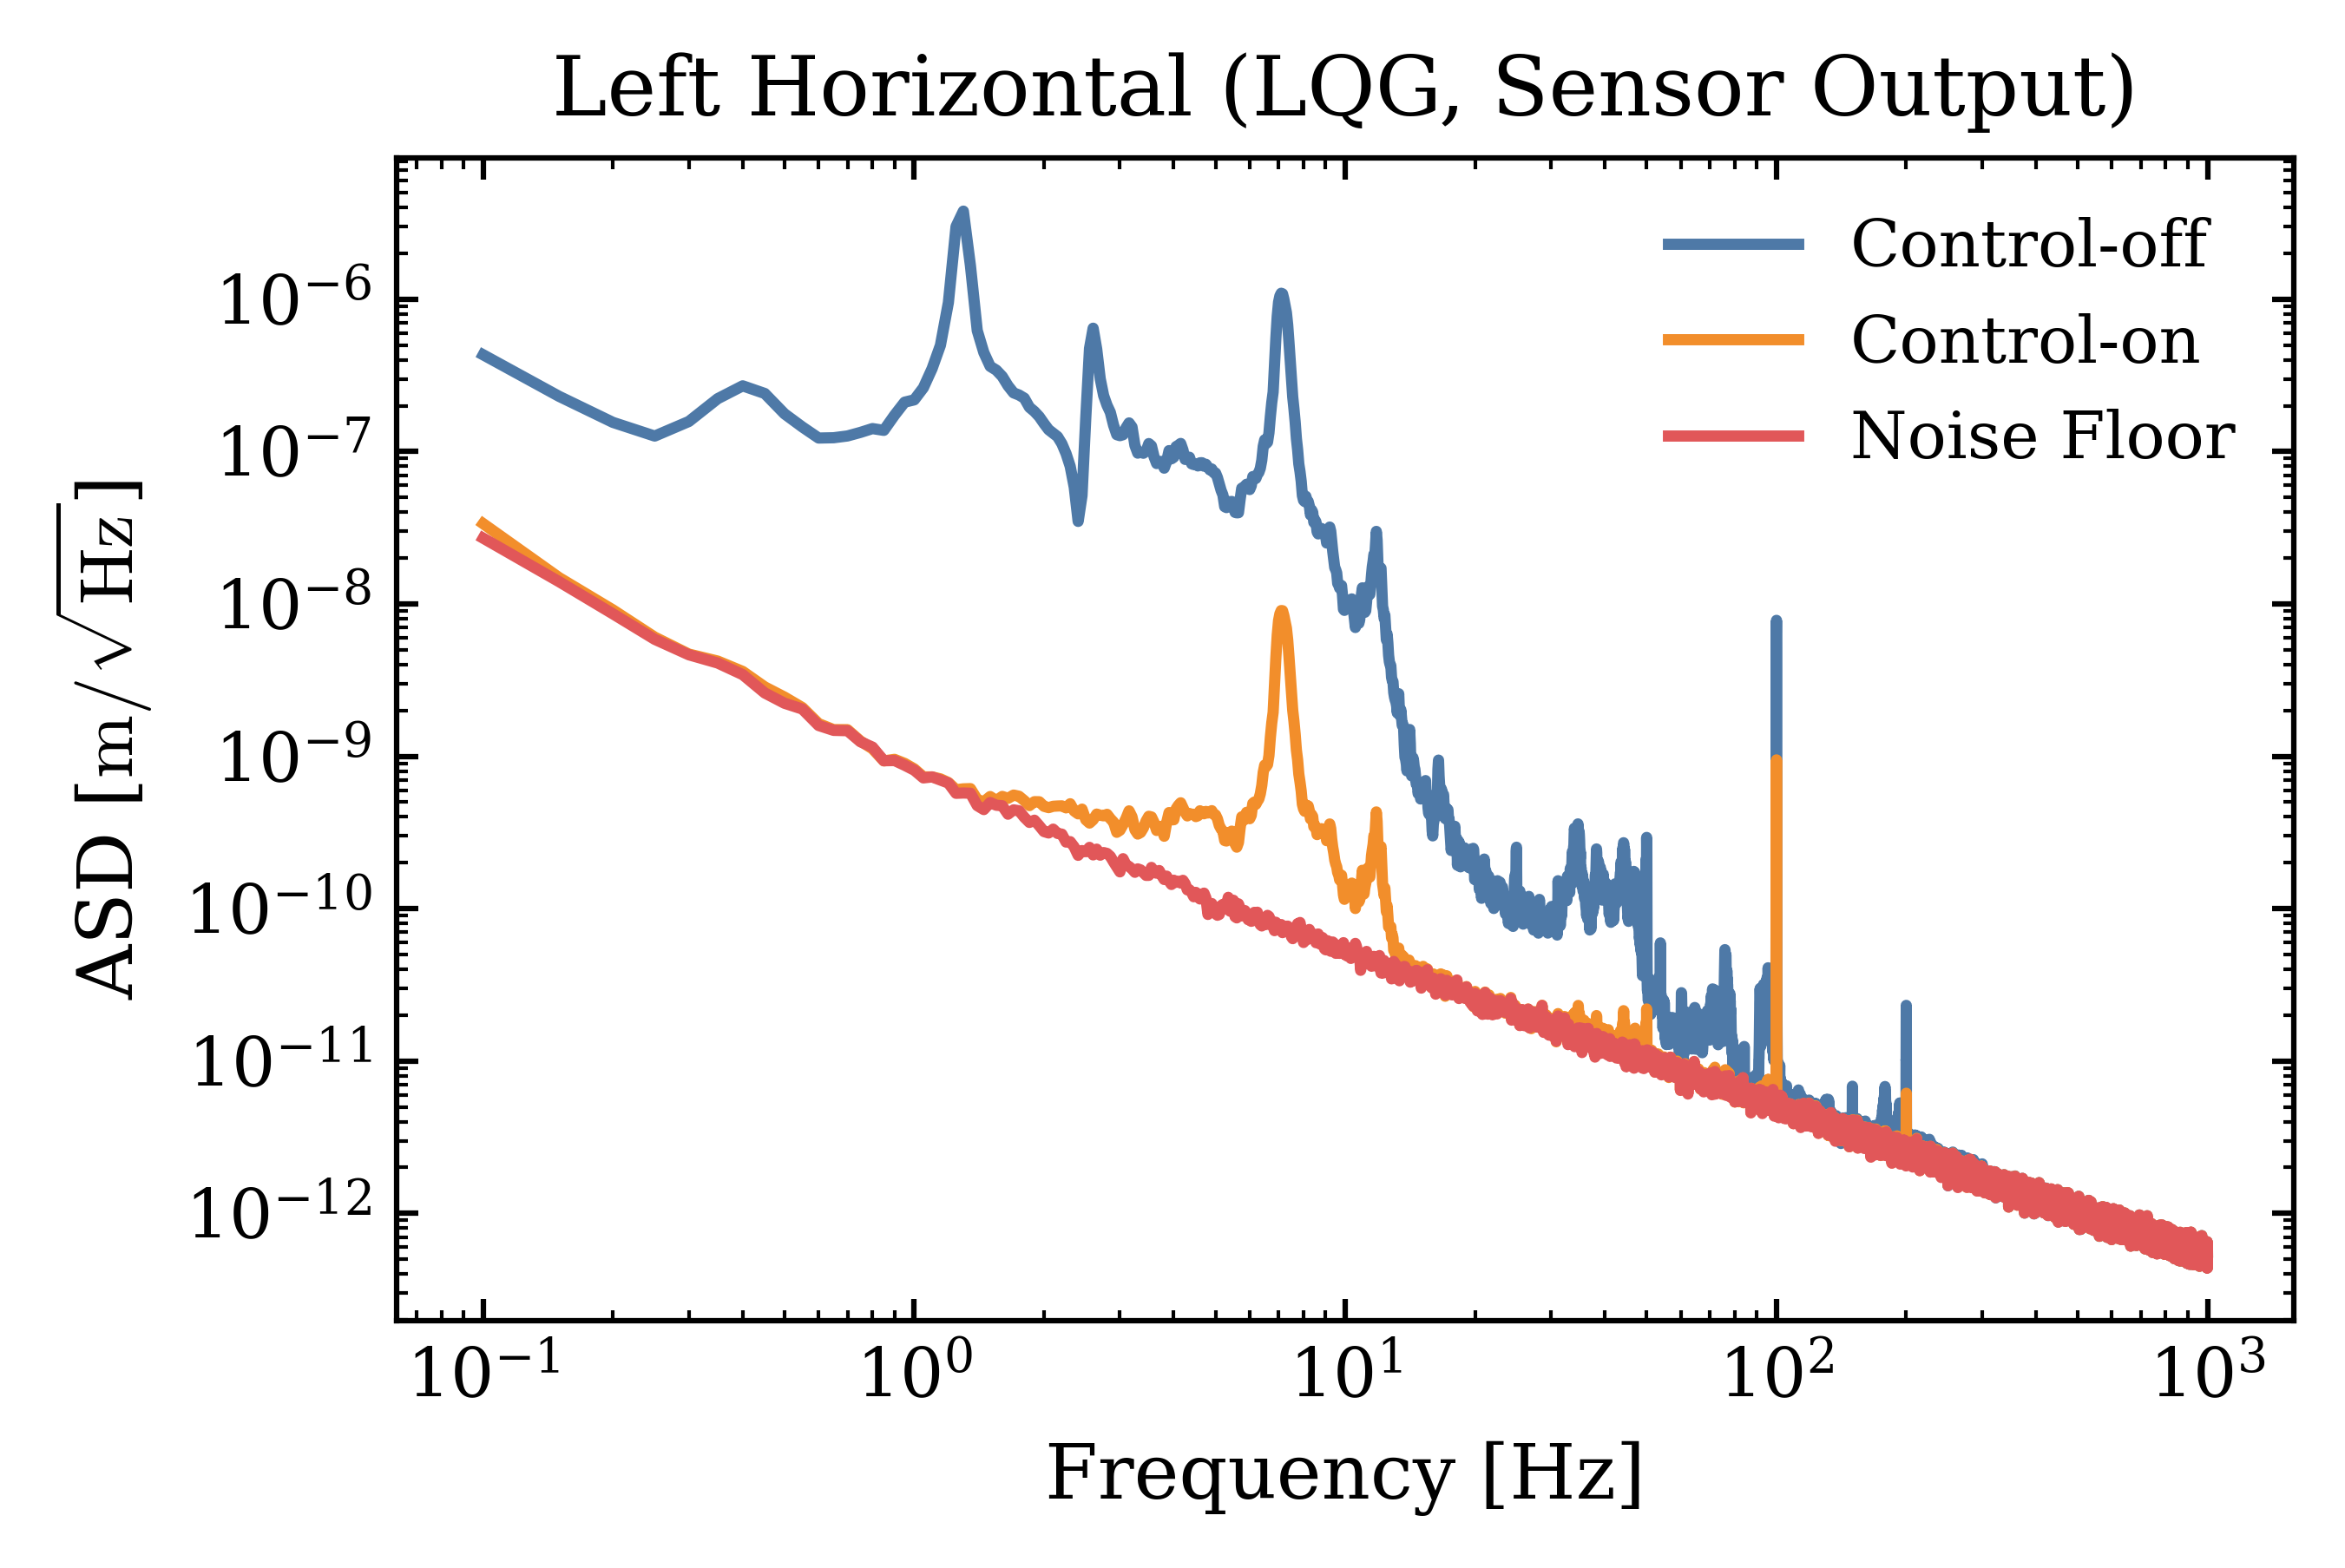

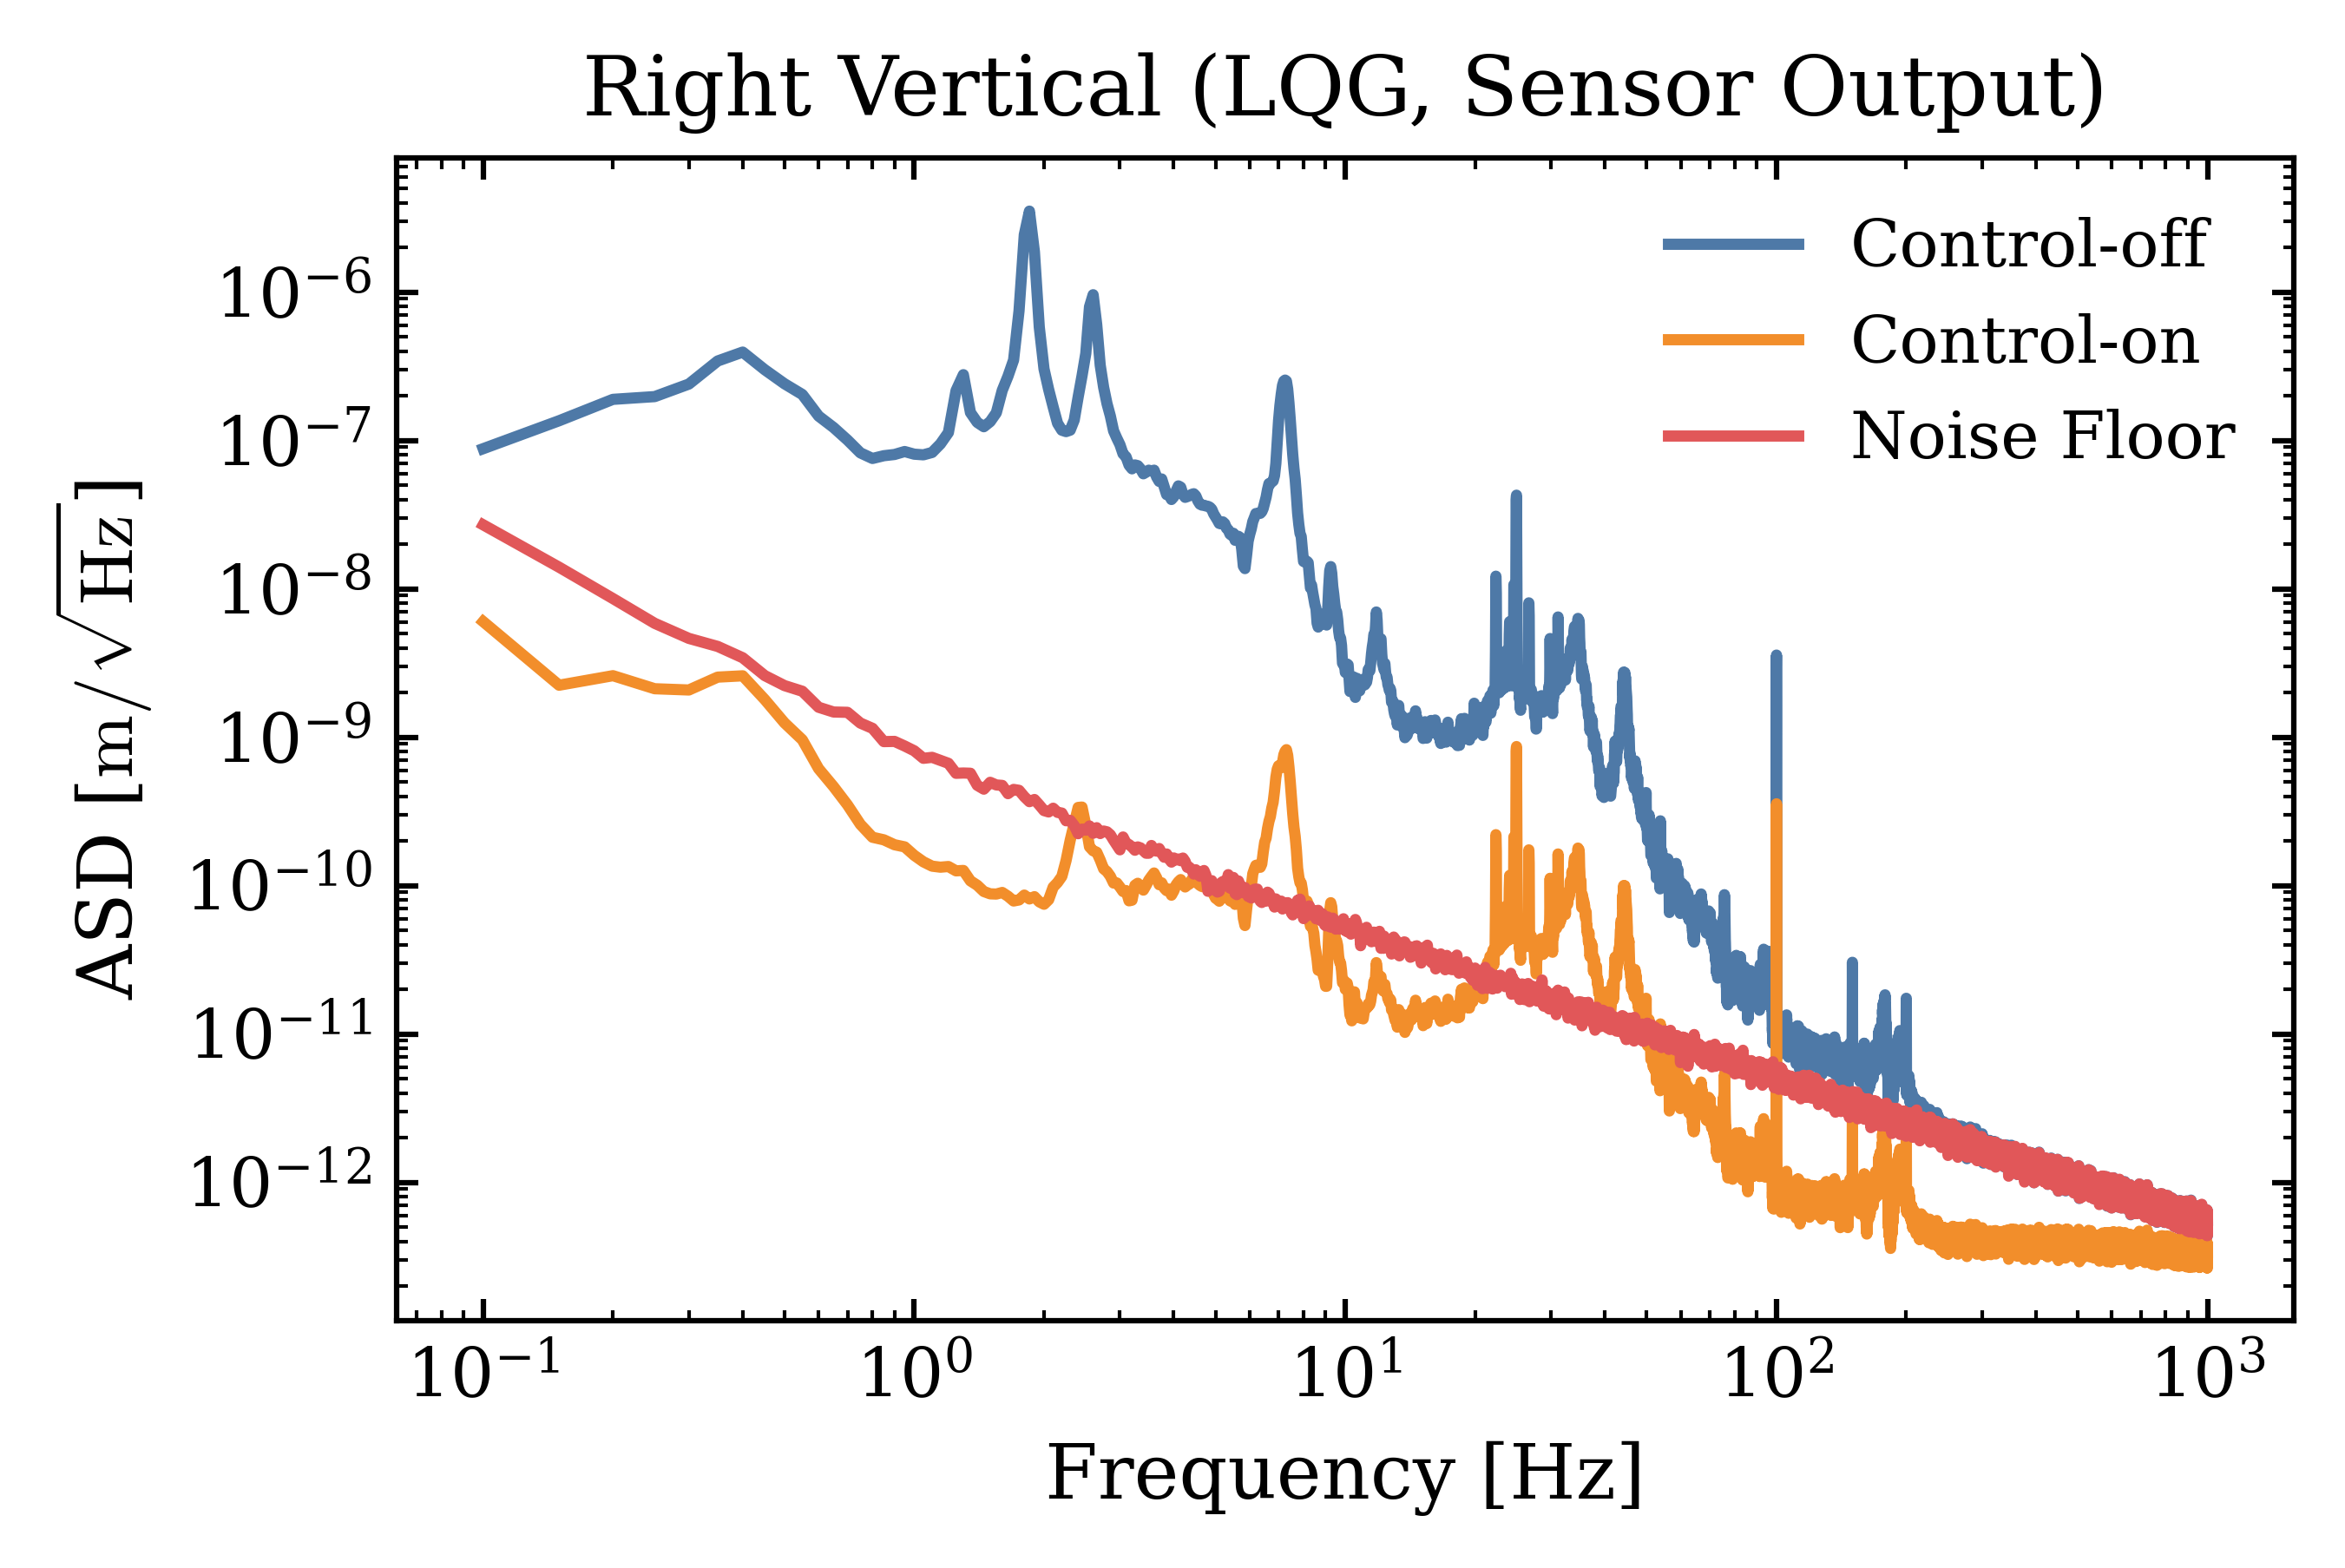

In [13]:
mb.mamplot(
    f, (d_asd_VL_o, d_asd_VL_c2, d_asd_ns), 
    ('Control-off', 'Control-on', 'Noise Floor'), 
    'Left Vertical (LQG, Sensor Output)',
    'Frequency [Hz]', 'ASD [$\mathrm{m/\sqrt{Hz}}$]',
    logx=True, logy=True, 
    legend_out=False, legend_fancy=False
)

mb.mamplot(
    f, (d_asd_HL_o, d_asd_HL_c2, d_asd_ns), 
    ('Control-off', 'Control-on', 'Noise Floor'), 
    'Left Horizontal (LQG, Sensor Output)',
    'Frequency [Hz]', 'ASD [$\mathrm{m/\sqrt{Hz}}$]',
    logx=True, logy=True, 
    legend_out=False, legend_fancy=False
)

mb.mamplot(
    f, (d_asd_VR_o, d_asd_VR_c2, d_asd_ns), 
    ('Control-off', 'Control-on', 'Noise Floor'), 
    'Right Vertical (LQG, Sensor Output)',
    'Frequency [Hz]', 'ASD [$\mathrm{m/\sqrt{Hz}}$]',
    logx=True, logy=True, 
    legend_out=False, legend_fancy=False
)

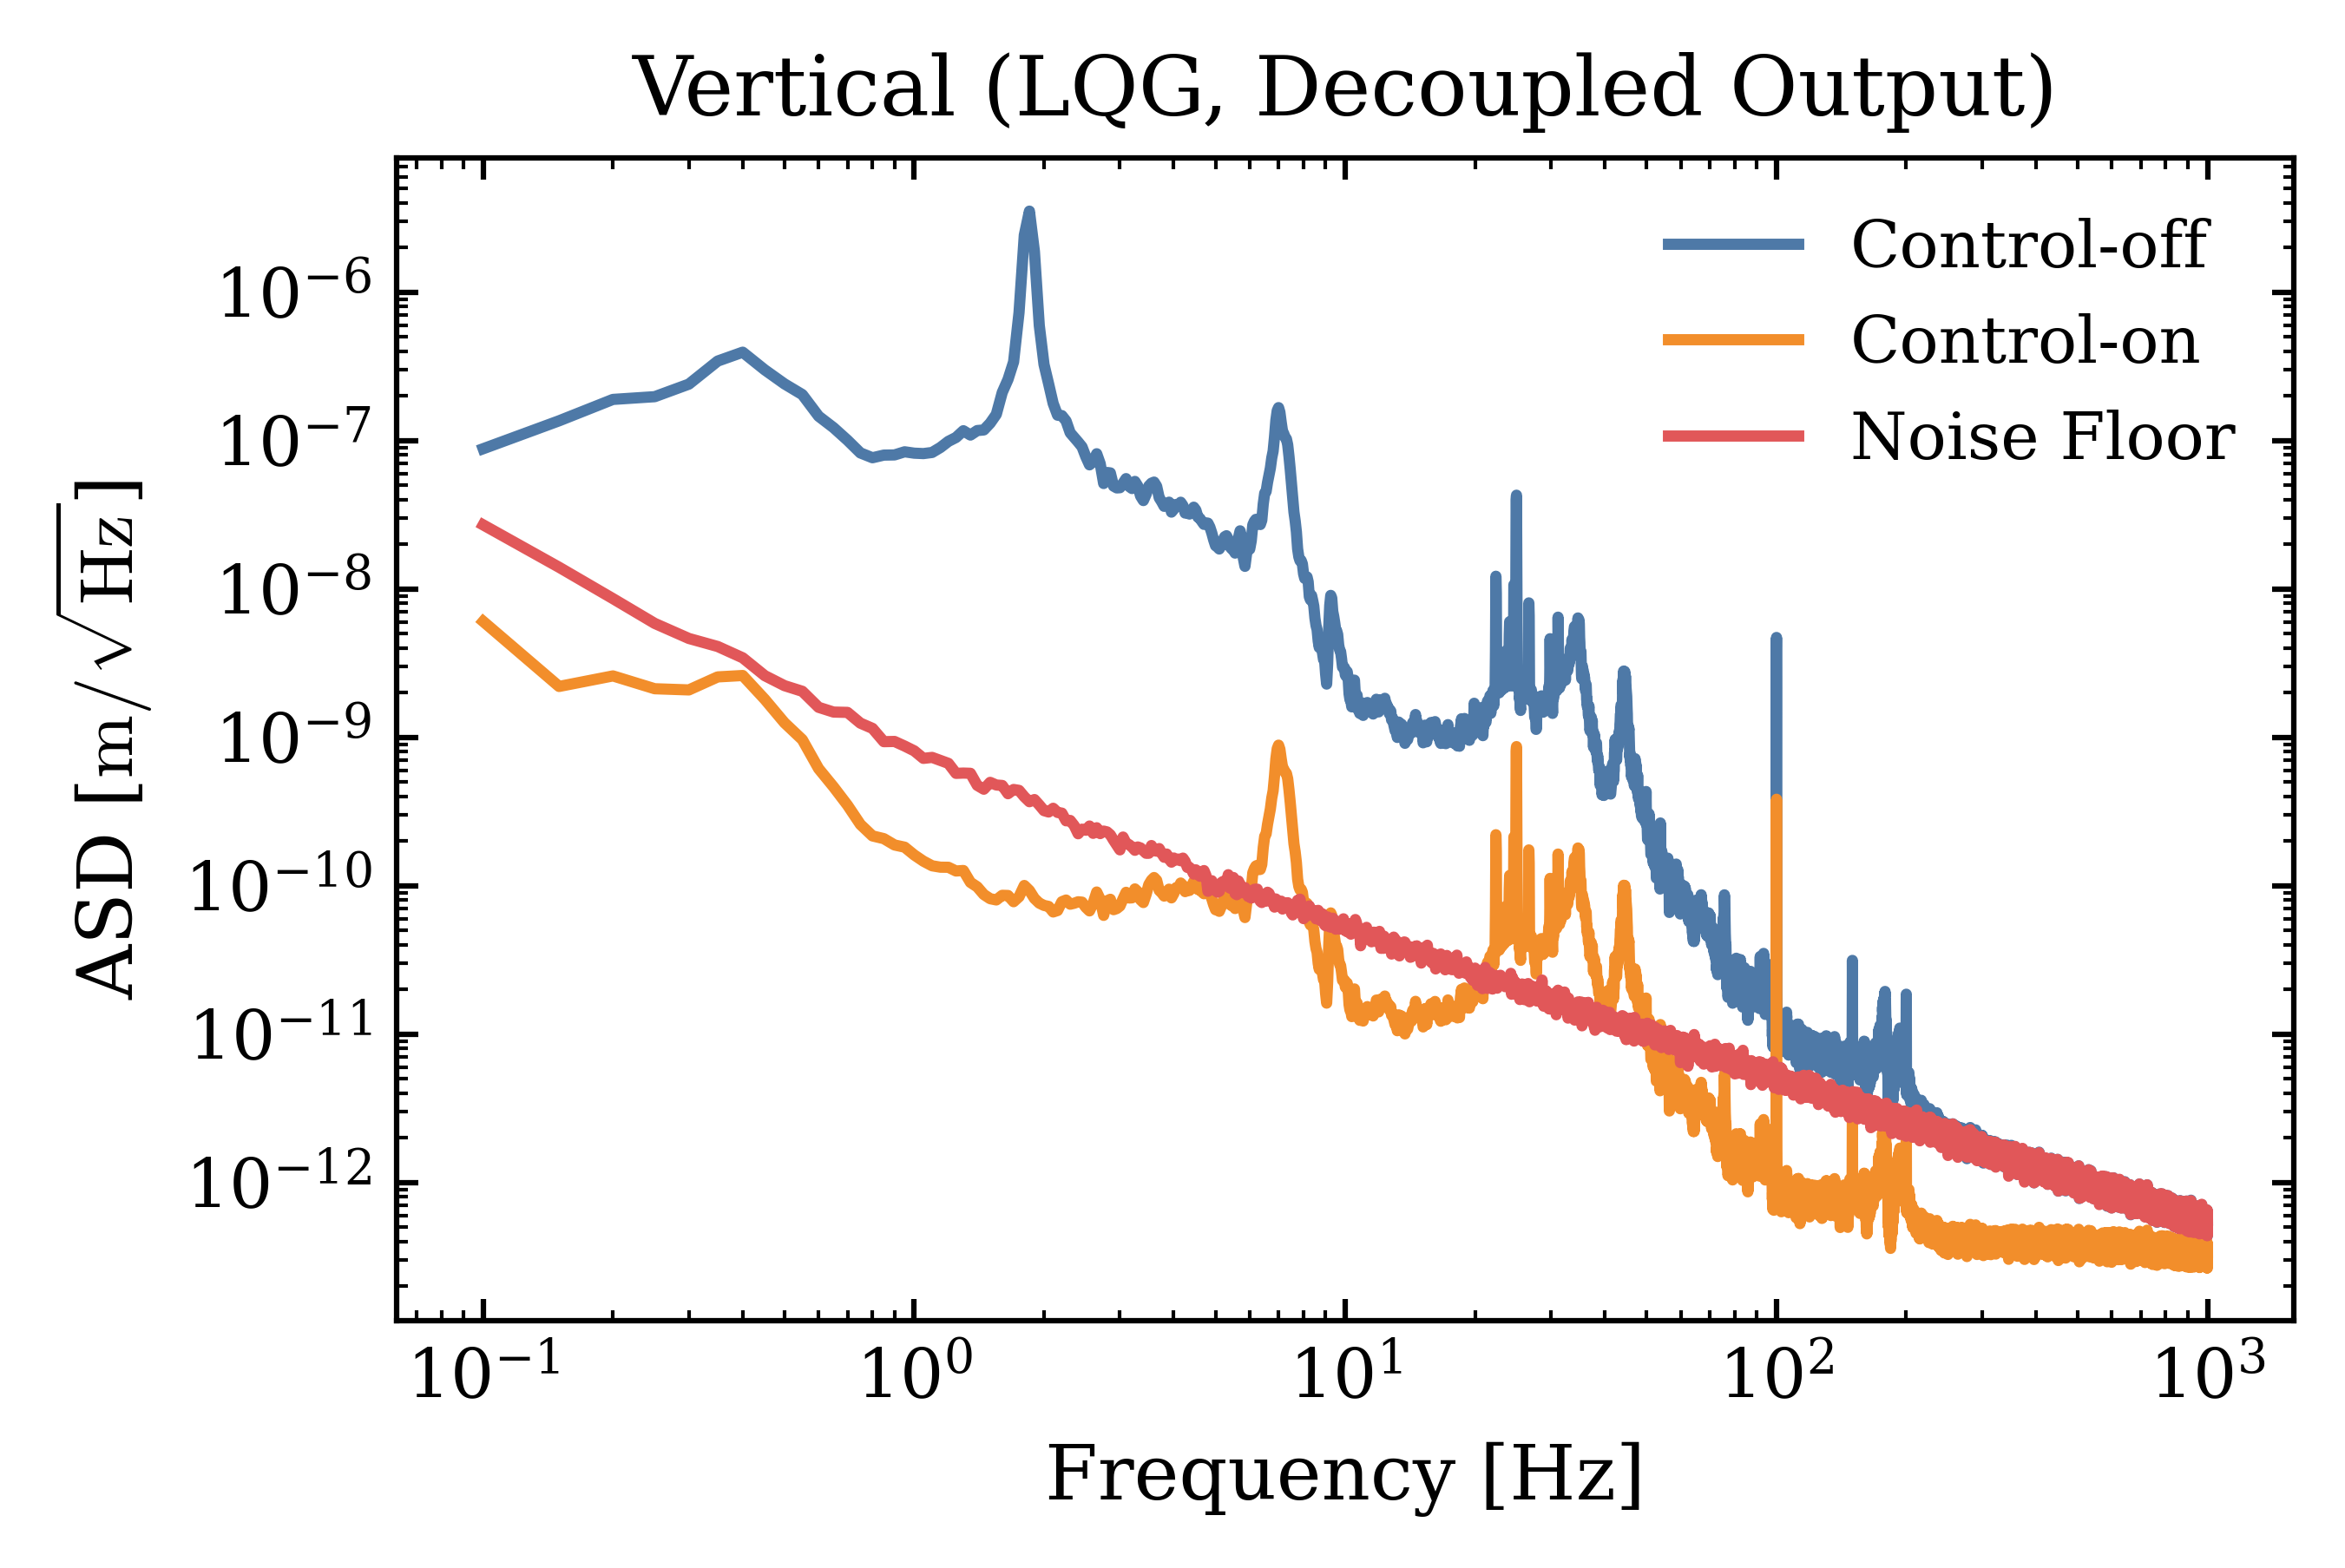

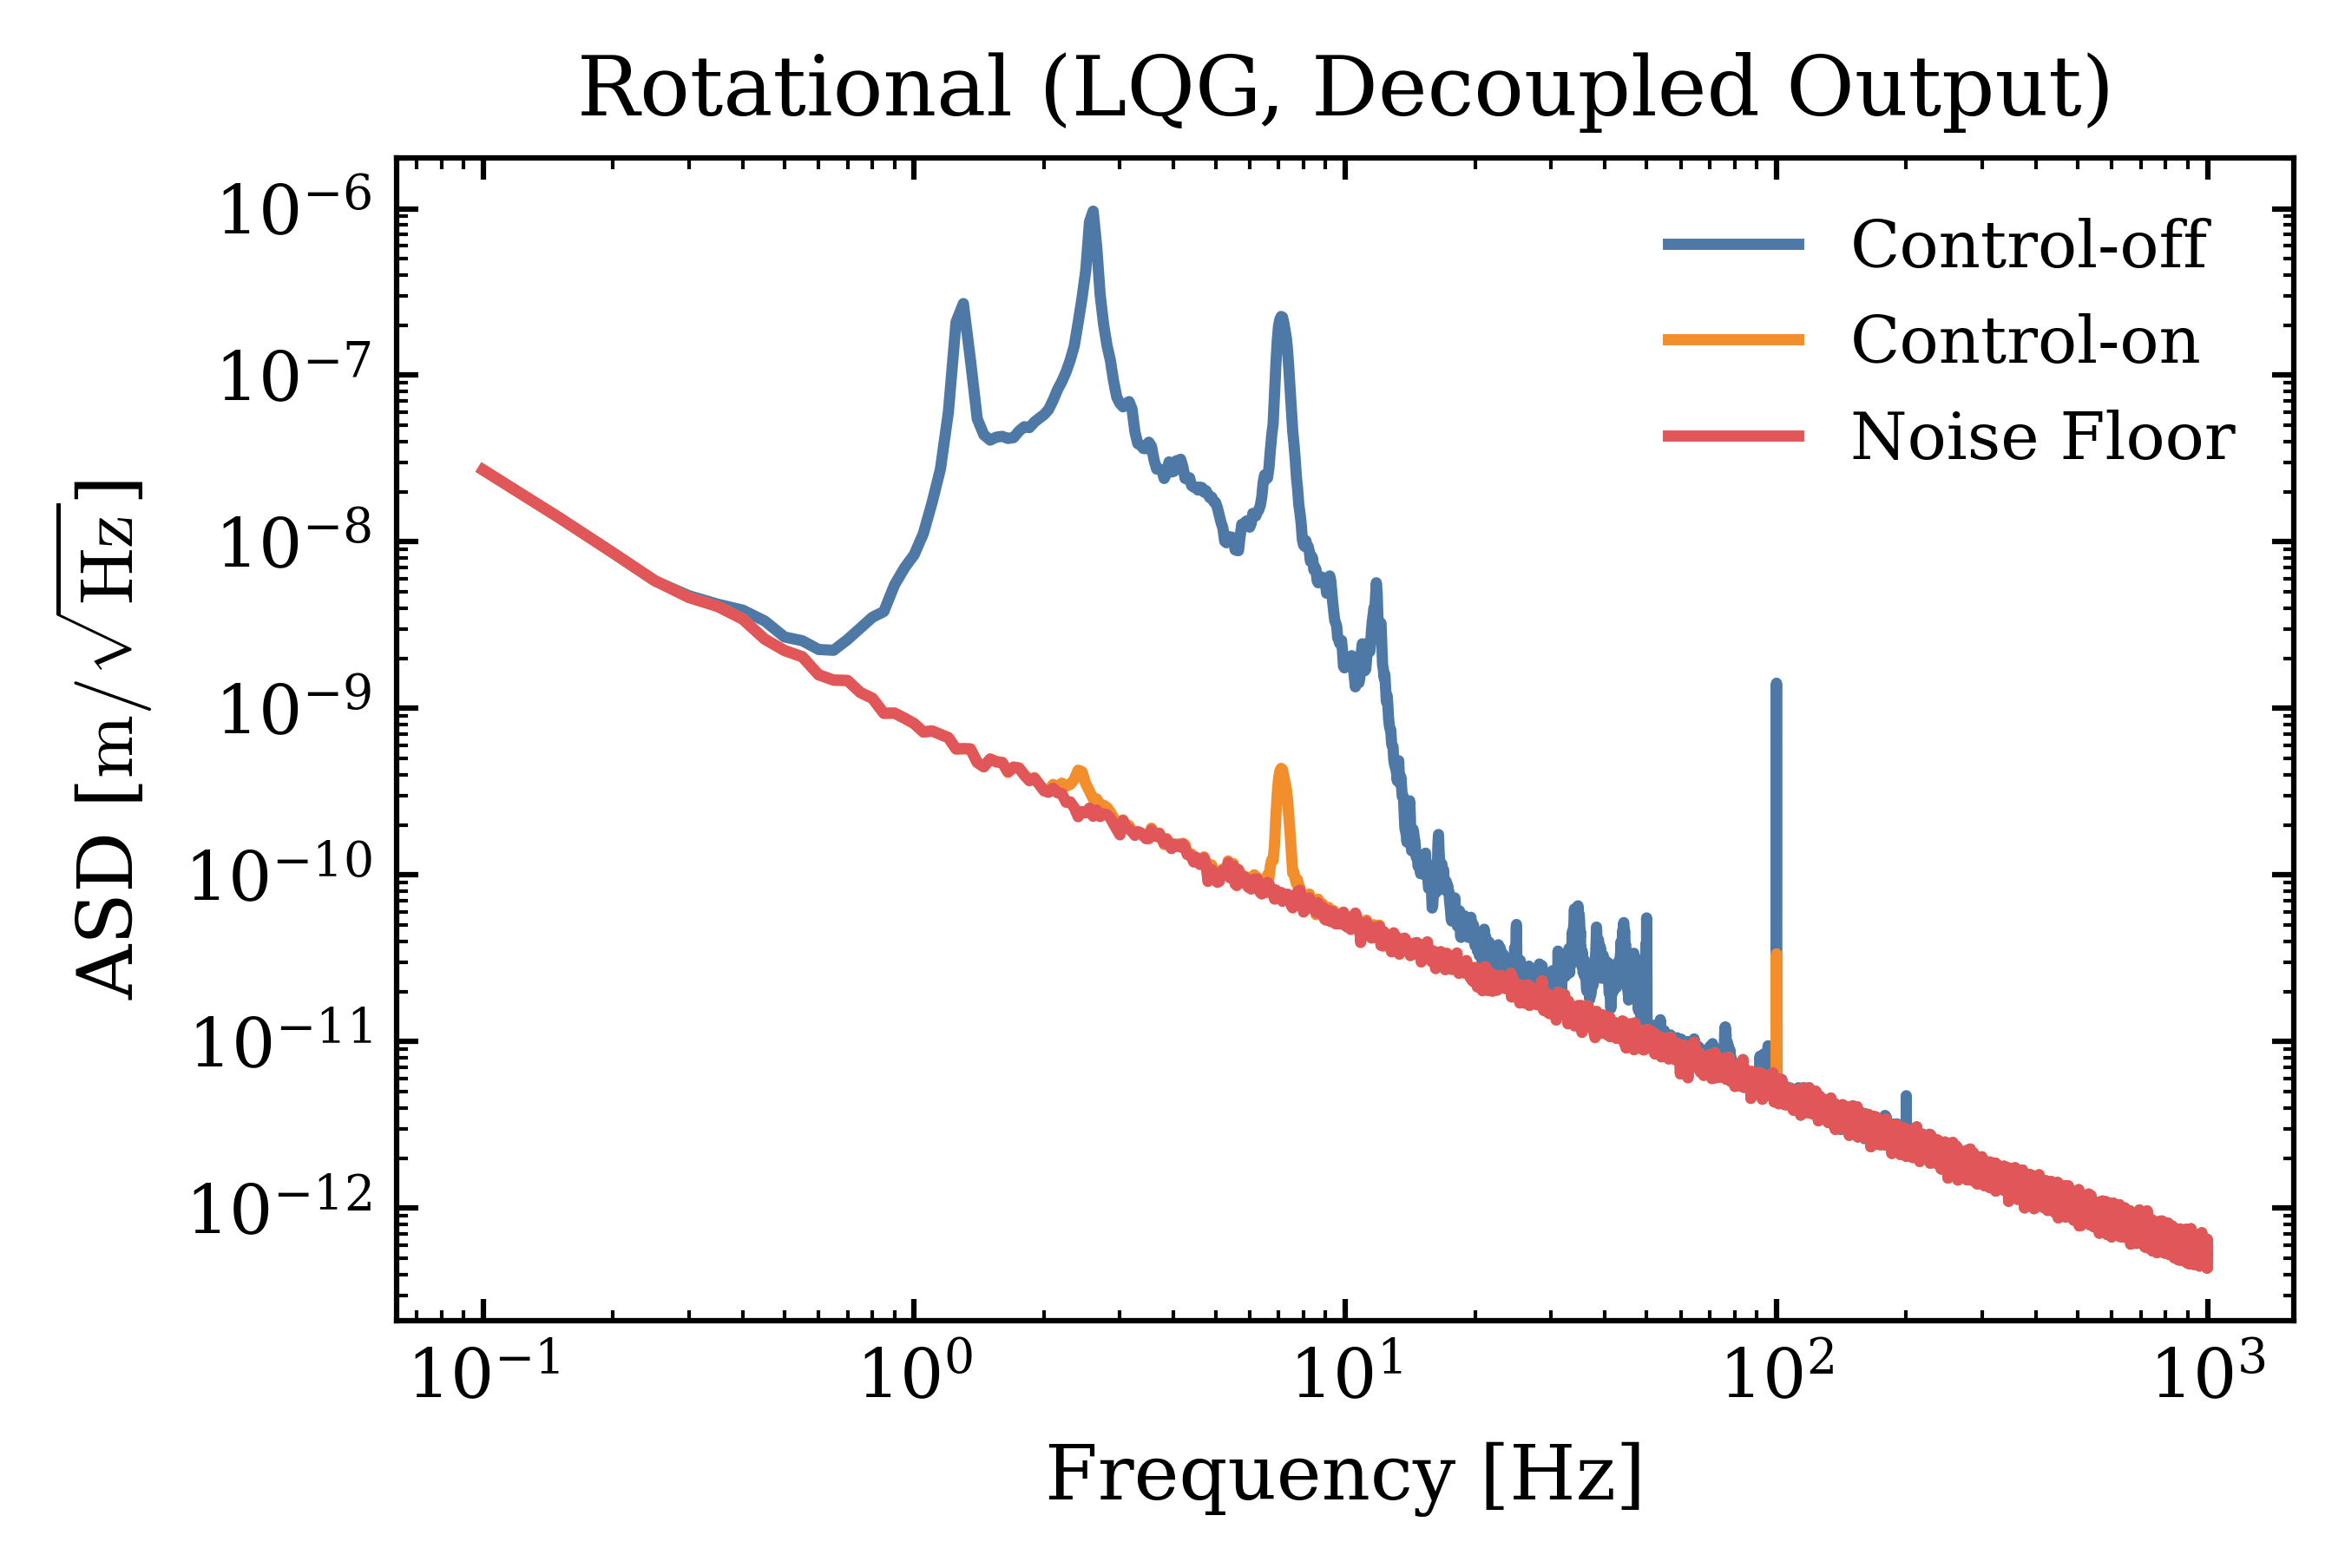

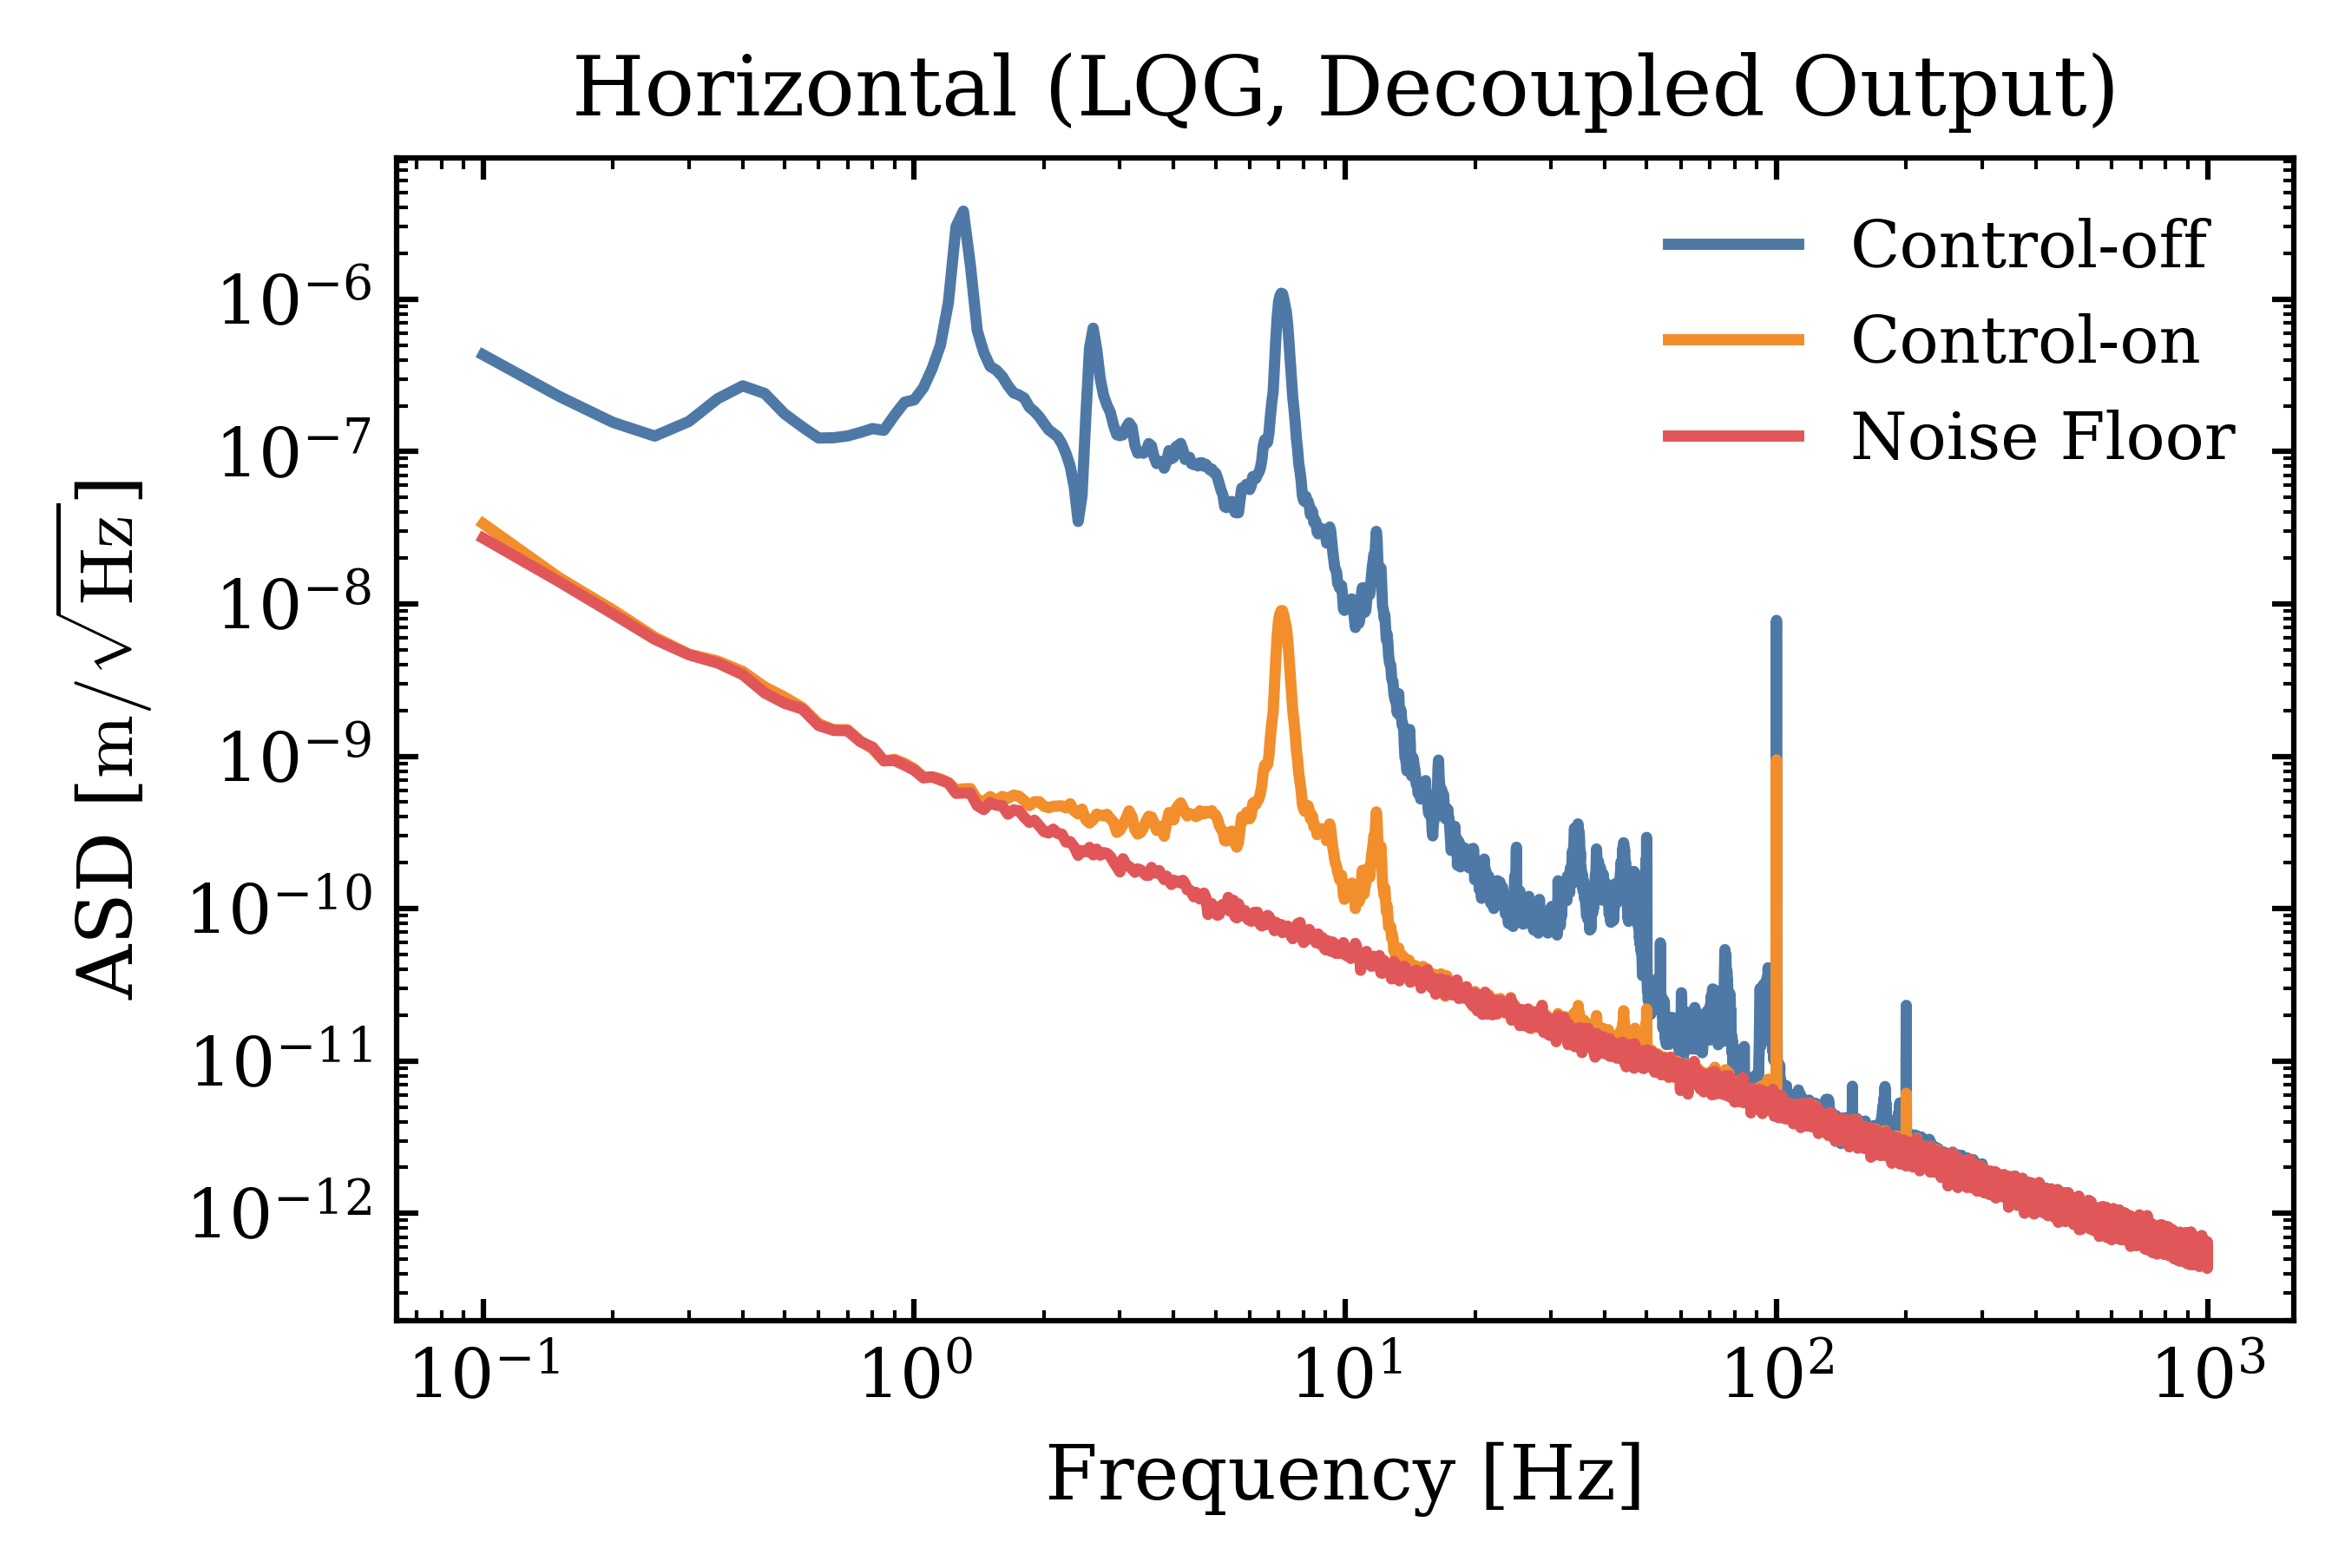

In [14]:
mb.mamplot(
    f, (d_asd_V_o, d_asd_V_c2, d_asd_ns), 
    ('Control-off', 'Control-on', 'Noise Floor'), 
    'Vertical (LQG, Decoupled Output)',
    'Frequency [Hz]', 'ASD [$\mathrm{m/\sqrt{Hz}}$]',
    logx=True, logy=True, 
    legend_out=False, legend_fancy=False
)

mb.mamplot(
    f, (d_asd_R_o, d_asd_R_c2, d_asd_ns), 
    ('Control-off', 'Control-on', 'Noise Floor'), 
    'Rotational (LQG, Decoupled Output)',
    'Frequency [Hz]', 'ASD [$\mathrm{m/\sqrt{Hz}}$]',
    logx=True, logy=True, 
    legend_out=False, legend_fancy=False
)

mb.mamplot(
    f, (d_asd_H_o, d_asd_H_c2, d_asd_ns), 
    ('Control-off', 'Control-on', 'Noise Floor'), 
    'Horizontal (LQG, Decoupled Output)',
    'Frequency [Hz]', 'ASD [$\mathrm{m/\sqrt{Hz}}$]',
    logx=True, logy=True, 
    legend_out=False, legend_fancy=False
)

## Save Data

存 **一组频率 + 多个数组**

比如现在有：

* `f`
* `d_asd_V`
* `d_asd_R`
* `d_asd_H`

```python
np.savez(
    "asd_result.npz",
    f=f,
    d_asd_V=d_asd_V,
    d_asd_R=d_asd_R,
    d_asd_H=d_asd_H
)
```

**读取：**

```python
data = np.load("asd_result.npz")
f = data["f"]
d_asd_V = data["d_asd_V"]
```


In [28]:
np.savez(
    "asd_lqg.npz",
    f=f,
    V=d_asd_V_c2,
    R=d_asd_R_c2,
    H=d_asd_H_c2,
    VL=d_asd_VL_c2,
    HL=d_asd_HL_c2,
    VR=d_asd_VR_c2
)